In [1]:
import h5py
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import Path
import pyfftw

import bacco

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plotter
import plot_utils
import utils
import compute_statistics as cs
import data_loader
import generate_params as genp

%load_ext autoreload
%autoreload 2

2026-01-27 23:25:24.593301: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-27 23:25:24.690534: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-27 23:25:24.690571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-27 23:25:24.702927: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-27 23:25:24.731597: I tensorflow/core/platform/cpu_feature_guar

# inference: noiseless, no reparam, kmax=0.4

In [2]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = None
tag_Anoise = None

n_train = 10000
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
#statistics_arr = [['pk'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
if tag_noise is None:
    tags_inf = [f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}_ntrain{n_train}' for tag_stats in tag_stats_arr]
else:
    tags_inf = [f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}_ntrain{n_train}' for tag_stats in tag_stats_arr]
    
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [3]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl']


### coverage

In [4]:
# load test set matched to training sest
tag_params_test = '_test_p5_n1000'
tags_biasparams_test = ['_biaszen_p4_n1000']*len(tags_inf)
tags_noise_test = None
tags_Anoise_test = None
tags_mask_test = ['', '', '']
tag_datagen_test = ''               

n_test_eval = None
if n_test_eval is not None:
    tags_data_test = ['_'+data_mode + tag_stats_arr[i] + tags_mask_test[i] + tag_params_test + tags_biasparams_test[i] + tag_datagen_test + f'_neval{n_test_eval}' for i in range(len(tag_stats_arr))]
else:
    tags_data_test = ['_'+data_mode + tag_stats_arr[i] + tags_mask_test[i] + tag_params_test + tags_biasparams_test[i] + tag_datagen_test for i in range(len(tag_stats_arr))]

for tag_data_test in tags_data_test:
    print(tag_data_test)

_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000
_muchisimocks_bispec_test_p5_n1000_biaszen_p4_n1000
_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000


In [5]:
#param_names_show = cosmo_param_names_vary + utils.biasparam_names_ordered
param_names_show = utils.param_names_all_ordered
#param_names_show = ['omega_cold', 'sigma8_cold', 'sigma8_cold_x_b1', \
#                   'sigma8_cold_sq_x_b2', 'sigma8_cold_sq_x_bs2', 'sigma8_cold_x_bl']
#param_names_show = cosmo_param_names_vary + ['b1']
theta_true_arr, theta_pred_arr, vars_pred_arr = [], [], []
covs_pred_arr = [] #note that this will be for all params, not just show, for now
for i, tag_inf in enumerate(tags_inf):

    _theta_test_pred, _covs_test_pred, param_names  = utils.get_moments_test_sbi(tag_inf, tag_test=tags_data_test[i],
                                                                     #param_names=param_names_show
                                                                     )
    print(param_names)                                                                
    theta_test = data_loader.load_theta_test(tag_params_test, tags_biasparams_test[i])
    if n_test_eval is not None:
        theta_test = theta_test[:n_test_eval]
    theta_true_inf, theta_pred_inf, vars_pred_inf = [], [], []
    for param_name_show in param_names_show:
        if param_name_show in param_names:
            idx_pn = list(param_names).index(param_name_show)
            theta_true_inf.append(theta_test[:,idx_pn])
            theta_pred_inf.append(_theta_test_pred[:,idx_pn])
            vars_pred_inf.append(_covs_test_pred[:,idx_pn,idx_pn])
            #covs_pred_arr.append(_covs_test_pred[:,idx_pn,idx_pn])
        else:
            nans = np.full(_theta_test_pred.shape[0], np.nan)
            theta_true_inf.append(nans)
            theta_pred_inf.append(nans)
            vars_pred_inf.append(nans)
            #covs_pred_arr.append(None)

    theta_true_arr.append(np.array(theta_true_inf).T)
    theta_pred_arr.append(np.array(theta_pred_inf).T)
    vars_pred_arr.append(np.array(vars_pred_inf).T)
    covs_pred_arr.append(_covs_test_pred)
    
theta_true_arr = np.array(theta_true_arr)
theta_pred_arr = np.array(theta_pred_arr)
vars_pred_arr = np.array(vars_pred_arr)
covs_pred_arr = np.array(covs_pred_arr)

fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_ntrain10000/samples_test_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_pred.npy
['omega_cold' 'sigma8_cold' 'hubble' 'omega_baryon' 'ns' 'b1' 'b2' 'bs2'
 'bl']
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_ntrain10000/samples_test_muchisimocks_bispec_test_p5_n1000_biaszen_p4_n1000_pred.npy
['omega_cold' 'sigma8_cold' 'hubble' 'omega_baryon' 'ns' 'b1' 'b2' 'bs2'
 'bl']
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_ntrain10000/samples_test_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000_pred.npy
['omega_cold' 'sigma8_cold' 'hubble' 'omega_baryon' 'ns' 'b1' 'b2' 'bs2'
 'bl']


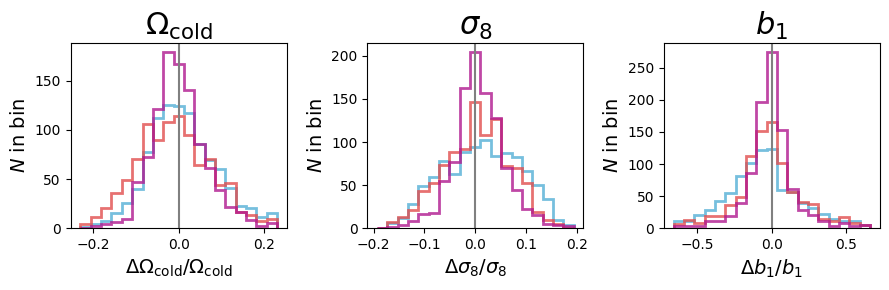

(3, 1000, 9)


In [6]:
param_names_key = ['omega_cold', 'sigma8_cold', 'b1']
fracdiffs_arr = plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, 
                        param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=20, alpha=0.8, histtype='step',
                        xlim_auto=False,
                        plot_cdf=False)
print(fracdiffs_arr.shape)
# for param_name in param_names_key:
#     std_fracdiffs_pk = np.std(fracdiffs_arr[0,:,param_names_show.index(param_name)])
#     std_fracdiffs_pk_bispec = np.std(fracdiffs_arr[2,:,param_names_show.index(param_name)])
#     improvement = std_fracdiffs_pk / std_fracdiffs_pk_bispec
#     print(f'{param_name}: {improvement:.3f} ({std_fracdiffs_pk:.3f} / {std_fracdiffs_pk_bispec:.3f})')
                        

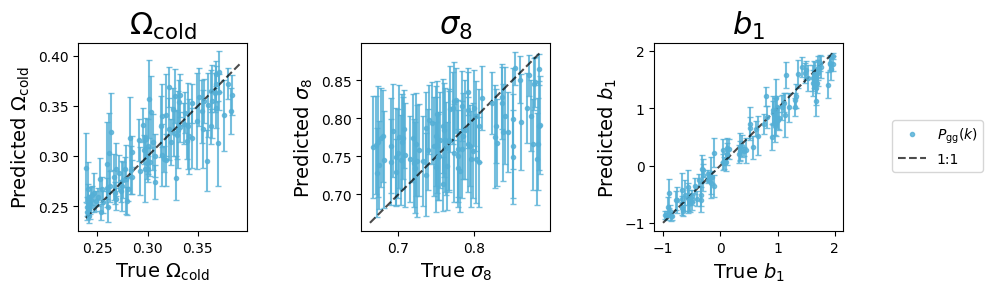

In [7]:
idx_stat = 0 # p
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], covs_pred_arr[idx_stat], param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)

# inference: noiseless, reparam, kmax=0.4

In [8]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = None
tag_Anoise = None
tag_reparam = '_rp'

n_train = 10000
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
#statistics_arr = [['pk']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
if tag_noise is None:
    tags_inf = [f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}{tag_reparam}_ntrain{n_train}' for tag_stats in tag_stats_arr]
else:
    tags_inf = [f'_{data_mode}{tag_stats}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}{tag_reparam}_ntrain{n_train}' for tag_stats in tag_stats_arr]
    
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [9]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl']


## coverage

In [10]:
# load test set matched to training sest
tag_params_test = '_test_p5_n1000'
tags_biasparams_test = ['_biaszen_p4_n1000']*len(tags_inf)
tags_noise_test = None
tags_Anoise_test = None
tags_mask_test = ['', '', '']
tag_datagen_test = ''               

n_test_eval = 100
if n_test_eval is not None:
    tags_data_test = ['_'+data_mode + tag_stats_arr[i] + tags_mask_test[i] + tag_params_test + tags_biasparams_test[i] + tag_datagen_test + f'_neval{n_test_eval}' for i in range(len(tag_stats_arr))]
else:
    tags_data_test = ['_'+data_mode + tag_stats_arr[i] + tags_mask_test[i] + tag_params_test + tags_biasparams_test[i] + tag_datagen_test for i in range(len(tag_stats_arr))]

for tag_data_test in tags_data_test:
    print(tag_data_test)

_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_neval100
_muchisimocks_bispec_test_p5_n1000_biaszen_p4_n1000_neval100
_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000_neval100


In [11]:
#param_names_show = cosmo_param_names_vary + utils.biasparam_names_ordered
#param_names_show = utils.param_names_all_ordered
param_names_show = ['omega_cold', 'sigma8_cold', 'sigma8_cold_x_b1', \
                   'sigma8_cold_sq_x_b2', 'sigma8_cold_sq_x_bs2', 'sigma8_cold_x_bl']
#param_names_show = cosmo_param_names_vary + ['b1']
theta_true_arr, theta_pred_arr, vars_pred_arr = [], [], []
covs_pred_arr = [] #note that this will be for all params, not just show, for now
for i, tag_inf in enumerate(tags_inf):

    _theta_test_pred, _covs_test_pred, param_names  = utils.get_moments_test_sbi(tag_inf, tag_test=tags_data_test[i],
                                                                     #param_names=param_names_show
                                                                     )
    print(param_names)                                                                
    # Load theta_test in original space
    theta_test = data_loader.load_theta_test(tag_params_test, tags_biasparams_test[i])
    if n_test_eval is not None:
        theta_test = theta_test[:n_test_eval]
    
    # Reparameterize theta_test if tag_reparam is set
    if tag_reparam is not None and tag_reparam != '':
        # Get original param_names for theta_test
        param_names_orig = param_names_vary.copy()
        # Reparameterize theta_test to match the reparameterized param_names from inference
        theta_test, param_names_test_reparam = utils.reparameterize_theta(theta_test, param_names_orig)
    else:
        param_names_test_reparam = param_names_vary.copy()
    
    theta_true_inf, theta_pred_inf, vars_pred_inf = [], [], []
    for param_name_show in param_names_show:
        if param_name_show in param_names:
            idx_pn = list(param_names).index(param_name_show)
            # Use reparameterized theta_test if applicable
            if param_name_show in param_names_test_reparam:
                idx_pn_test = list(param_names_test_reparam).index(param_name_show)
                theta_true_inf.append(theta_test[:,idx_pn_test])
            else:
                # If param_name_show is not in param_names_test_reparam, it might be a reparameterized param
                # that we need to compute from original params
                theta_true_inf.append(np.full(theta_test.shape[0], np.nan))
            theta_pred_inf.append(_theta_test_pred[:,idx_pn])
            vars_pred_inf.append(_covs_test_pred[:,idx_pn,idx_pn])
            #covs_pred_arr.append(_covs_test_pred[:,idx_pn,idx_pn])
        else:
            nans = np.full(_theta_test_pred.shape[0], np.nan)
            theta_true_inf.append(nans)
            theta_pred_inf.append(nans)
            vars_pred_inf.append(nans)
            #covs_pred_arr.append(None)

    theta_true_arr.append(np.array(theta_true_inf).T)
    theta_pred_arr.append(np.array(theta_pred_inf).T)
    vars_pred_arr.append(np.array(vars_pred_inf).T)
    covs_pred_arr.append(_covs_test_pred)
    
theta_true_arr = np.array(theta_true_arr)
theta_pred_arr = np.array(theta_pred_arr)
vars_pred_arr = np.array(vars_pred_arr)
covs_pred_arr = np.array(covs_pred_arr)

fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_rp_ntrain10000/samples_test_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000_neval100_pred.npy
['omega_cold' 'sigma8_cold' 'sigma8_cold_x_b1' 'sigma8_cold_sq_x_b2'
 'sigma8_cold_sq_x_bs2' 'sigma8_cold_x_bl']
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_bispec_p5_n10000_biaszen_p4_n200000_rp_ntrain10000/samples_test_muchisimocks_bispec_test_p5_n1000_biaszen_p4_n1000_neval100_pred.npy
['omega_cold' 'sigma8_cold' 'sigma8_cold_x_b1' 'sigma8_cold_sq_x_b2'
 'sigma8_cold_sq_x_bs2' 'sigma8_cold_x_bl']
fn_samples_test_pred = ../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_rp_ntrain10000/samples_test_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000_neval100_pred.npy


FileNotFoundError: [Errno 2] No such file or directory: '../results/results_sbi/sbi_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n200000_rp_ntrain10000/samples_test_muchisimocks_pk_bispec_test_p5_n1000_biaszen_p4_n1000_neval100_pred.npy'

In [ ]:
param_names_key = ['omega_cold', 'sigma8_cold', 'sigma8_cold_x_b1']
fracdiffs_arr = plotter.plot_dists_mean_subplots(theta_pred_arr, theta_true_arr, param_names_show, 
                        param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=colors, label_arr=labels,
                        n_bins=20, alpha=0.8, histtype='step',
                        xlim_auto=False,
                        plot_cdf=False)
print(fracdiffs_arr.shape)
# for param_name in param_names_key:
#     std_fracdiffs_pk = np.std(fracdiffs_arr[0,:,param_names_show.index(param_name)])
#     std_fracdiffs_pk_bispec = np.std(fracdiffs_arr[2,:,param_names_show.index(param_name)])
#     improvement = std_fracdiffs_pk / std_fracdiffs_pk_bispec
#     print(f'{param_name}: {improvement:.3f} ({std_fracdiffs_pk:.3f} / {std_fracdiffs_pk_bispec:.3f})')
                        

TypeError: unsupported operand type(s) for /: 'list' and 'list'

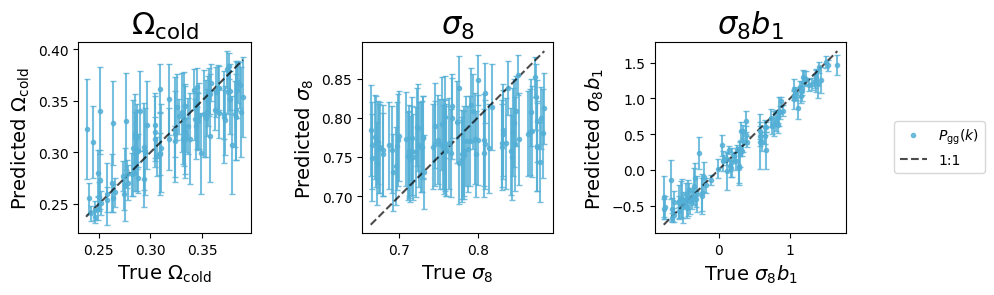

In [ ]:
idx_stat = 0 # p
fracdiffs_arr = plotter.plot_comp_mean_subplots(theta_pred_arr[idx_stat], theta_true_arr[idx_stat], covs_pred_arr[idx_stat], param_names_show, param_names_plot=param_names_key, param_label_dict=utils.param_label_dict,
                        color_arr=[colors[idx_stat]], label_arr=[labels[idx_stat]],
                        alpha=0.8, N_plot=100)